# Excerise - MNIST
Modified National Institue of Standards and Technology 'MNIST' dataset is hello world Machine Learning of handwritten digits, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. More information at
- [https://www.tensorflow.org/datasets/catalog/mnist](https://www.tensorflow.org/datasets/catalog/mnist)
- [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/)

In this excerise, will practise below tasks
- load dataset
- explore
- wrangle
- train model to predict

## Load dataset

In [35]:
import ssl, os, warnings
import numpy as np
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
assert tf.__version__ >= "2.5"

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

model_name = './models.h5/mnist.h5'

# BEGIN: fix Python or Notebook SSL CERTIFICATE_VERIFY_FAILED
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context
# END: fix Python or Notebook SSL CERTIFICATE_VERIFY_FAILED

TensorFlow version: 2.5.1


## Using TF

In [36]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# print(f" X_train: {np.unique(X_train, return_counts=True)}")
# print(f" y_train: {np.unique(y_train, return_counts=True)}")
# print(f" X_test: {np.unique(X_test, return_counts=True)}")
# print(f" y_test: {np.unique(y_test, return_counts=True)}")

In [54]:
print(f" X_train training samples; length: {len(X_train)} shape: {X_train.shape}   type: {X_train.dtype} ")
print(f" y_train shape: {y_train.shape}   type: {y_train.dtype}")
print(f" X_test test samples; length: {len(X_test)}  shape: {X_test.shape}   type: {X_test.dtype}")
print(f" y_test shape: {y_test.shape}   type: {y_test.dtype}")

 X_train training samples; length: 60000 shape: (60000, 28, 28)   type: uint8 
 y_train shape: (60000,)   type: uint8
 X_test test samples; length: 10000  shape: (10000, 28, 28)   type: uint8
 y_test shape: (10000,)   type: uint8


In [38]:
print(f"Labels: {np.unique(y_train, return_counts=True)}")

Labels: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


### Display few images
Display sample of 25 (5 x 5) images

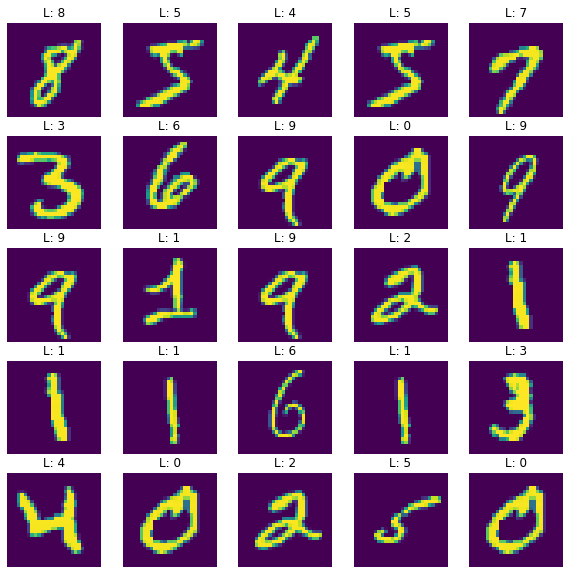

In [39]:
import matplotlib.pyplot as plt
def display_few_images(sample_images, sample_labels):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        idx = np.random.randint(0, len(sample_images))
        img = sample_images[idx]
        label = sample_labels[idx]
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.title(f"L: {label}")
        plt.imshow(img)
    plt.show()

display_few_images(X_train[:25], y_train[:25])

## Using TDFS

In [40]:
import tensorflow_datasets as tfds

In [41]:
mnist_train, info = tfds.load('mnist', split='train', as_supervised=True, with_info=True)
mnist_test = tfds.load('mnist', split='test', as_supervised=True)

### Show train data

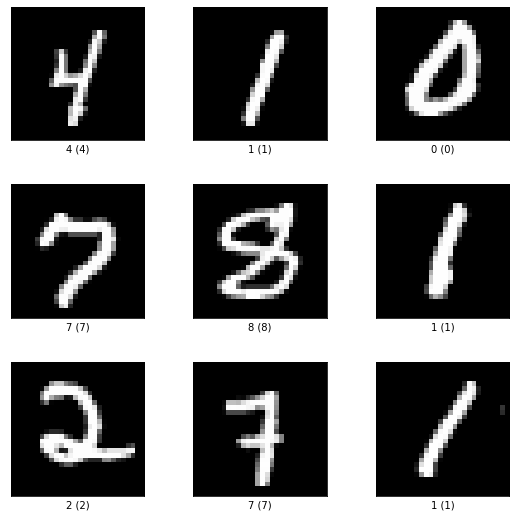

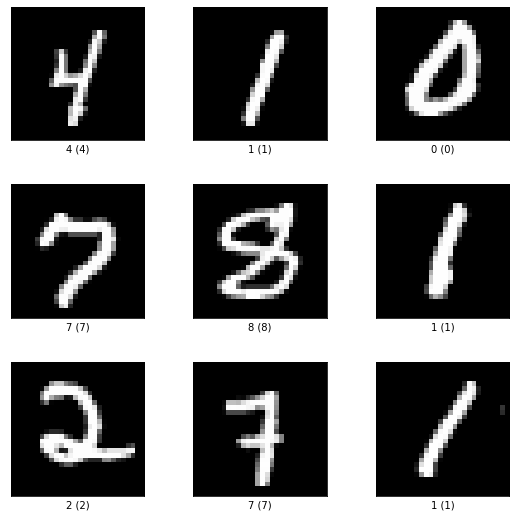

In [42]:
tfds.show_examples(mnist_train, info)

### Show test data

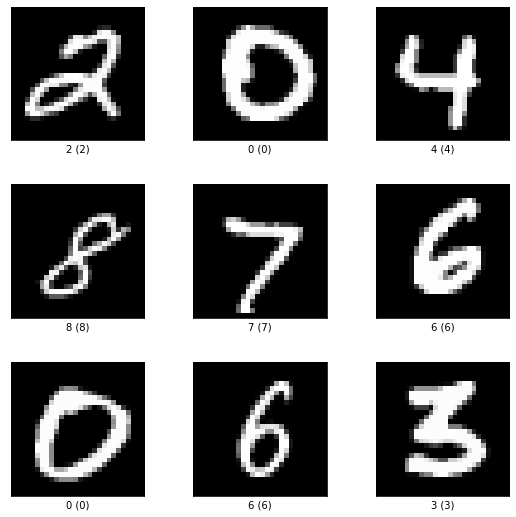

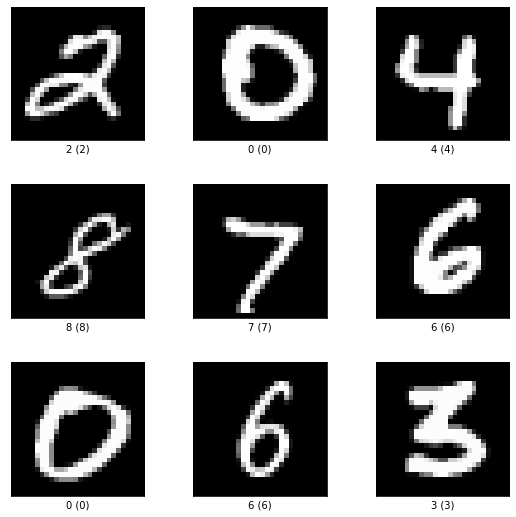

In [43]:
tfds.show_examples(mnist_test, info)

#### Number of classes, label names:

In [44]:
print(f"Number of classes: {info.features['label'].num_classes}")
print(f"Label names : {info.features['label'].names}")

Number of classes: 10
Label names : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


#### Shapes, dtypes:

In [45]:
print(f" Label shape: {info.features.shape}")
print(f" Label type: {info.features.dtype}")
print(f" Image shape: {info.features['image'].shape}")
print(f" Image type: {info.features['image'].dtype}")

 Label shape: {'image': (28, 28, 1), 'label': ()}
 Label type: {'image': tf.uint8, 'label': tf.int64}
 Image shape: (28, 28, 1)
 Image type: <dtype: 'uint8'>


In [46]:
print(f" Train dataset size: {info.splits['train'].num_examples}")
print(f" Test dataset size: {info.splits['test'].num_examples}")
print(f" Train dataset shards: {info.splits['train'].num_shards}")
print(f" Test dataset shards: {info.splits['test'].num_shards}")

 Train dataset size: 60000
 Test dataset size: 10000
 Train dataset shards: 1
 Test dataset shards: 1


#### Wrangle dataset
Normalize data to values between 0 & 1.

In [47]:
def tfds_wrangle_data(dataset, split_name):
    wrangle = dataset.map(lambda image, label: (tf.cast(image, tf.float32) / 255.0, label))
    wrangle = wrangle.cache()
    if split_name == 'train':
        dataset = dataset.shuffle(info.splits[split_name].num_examples)
    return wrangle.batch(64).prefetch(tf.data.AUTOTUNE)

In [48]:
train_data = tfds_wrangle_data(mnist_train, 'train')
train_data

<PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>

In [49]:
test_data = tfds_wrangle_data(mnist_test, 'test')
test_data

<PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>

#### Create Model

In [50]:
model_exists = os.path.exists(model_name)
tfds_model = None        
if model_exists:  # Check if model exists
    print('model already exists and loading it....')
    tfds_model = tf.keras.models.load_model(model_name)
else:
    print('model does not exist and creating it....')
    tfds_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(info.features['image'].shape),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    tfds_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

tfds_model.summary()

model already exists and loading it....
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


#### Fit the model

In [51]:
# mfit = model.fit(train_data, epochs=5, validation_data=test_data)
mfit = tfds_model.fit(train_data, epochs=5)
mfit

Epoch 1/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0181 - accuracy: 0.9969
Epoch 2/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0156 - accuracy: 0.9973
Epoch 3/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0135 - accuracy: 0.9980
Epoch 4/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0118 - accuracy: 0.9983
Epoch 5/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0101 - accuracy: 0.9986


#### Evaluate model using test data

In [52]:
tfds_model.evaluate(test_data)

157/157 [==============================] - 1s 4ms/step - loss: 0.1398 - accuracy: 0.9650


[0.13976526260375977, 0.9649999737739563]

#### Save model

In [53]:
tfds_model.save(model_name)
